In [118]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.cluster import KMeans

In [119]:
# Load image
patches = np.load('/oasis/projects/nsf/csd395/yuncong/CSHL_data_patches/patches/patches_12N_106.npy');
print "image shape %s" %(patches.shape,);

image shape (163, 224, 224, 3)


In [120]:
image = patches[0];
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY);
x_size = image.shape[0];
y_size = image.shape[1];

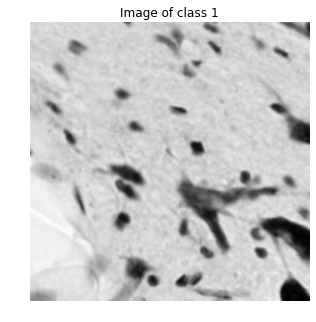

In [121]:
plt.figure(figsize=(5, 5));
plt.imshow(image, cmap=plt.cm.gray);
plt.axis('off');
plt.title('Image of class 1');

In [122]:
sift = cv2.SIFT();
key_point, descriptor = sift.detectAndCompute(image, None);

In [123]:
print len(key_point);
print "%s" %(descriptor.shape,);
print "({}, {})".format(key_point[0].pt[0], key_point[0].pt[1]);


242
(242, 128)
(139.168334961, 98.9727859497)


In [124]:
L = 3;      # Number of levels
M = 200;    # Number of channels (feature types)

# Apply k-means to assign each keypoint a label from 1 to M.
kmeans = KMeans(init='random', n_clusters=M, n_init=10);
kmeans.fit(descriptor);
cluster_labels = kmeans.predict(descriptor);

In [125]:
# Level 0
histogram = np.zeros(M, dtype=float);
weight_0 = 0.25;
for i in range(0, len(key_point)):
    histogram[cluster_labels[i]] += 1;
histogram = histogram * weight_0;

In [126]:
# Level 1
weight_1 = 0.25;
for i in range(0, 4):
    grid_x = 1.0* x_size / 4;
    grid_y = 1.0 * y_size / 4;
    x_min = i * grid_x;
    x_max = x_min + grid_x;
    y_min = i * grid_y;
    y_max = y_min + grid_y;
    histogram_tmp = np.zeros(M, dtype=float);
    for j in range(0, len(key_point)):
        if (x_min <= key_point[j].pt[0] <= x_max and
            y_min <= key_point[j].pt[1] <= y_max):
            histogram_tmp[cluster_labels[j]] += 1;
    histogram_tmp = histogram_tmp * weight_1;
    histogram = np.hstack((histogram, histogram_tmp));
print histogram.shape[0];

1000


In [127]:
# Level 2
weight_2 = 0.5;
for i in range(0, 16):
    grid_x = 1.0* x_size / 16;
    grid_y = 1.0 * y_size / 16;
    x_min = i * grid_x;
    x_max = x_min + grid_x;
    y_min = i * grid_y;
    y_max = y_min + grid_y;
    histogram_tmp = np.zeros(M, dtype=float);
    for j in range(0, len(key_point)):
        if (x_min <= key_point[j].pt[0] <= x_max and
            y_min <= key_point[j].pt[1] <= y_max):
            histogram_tmp[cluster_labels[j]] += 1;
    histogram_tmp = histogram_tmp * weight_1;
    histogram = np.hstack((histogram, histogram_tmp));
print histogram.shape[0];

4200


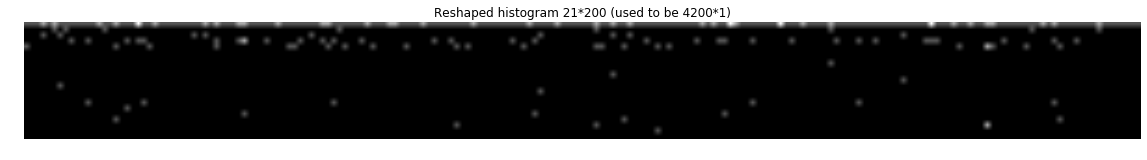

In [128]:
display_histogram = histogram.reshape(21, 200);
plt.figure(figsize=(20, 40));
plt.imshow(display_histogram, cmap=plt.cm.gray);
plt.axis('off');
plt.title('Reshaped histogram 21*200 (used to be 4200*1)');